In [ ]:
# try : 
#     from google.colab import files
# except:
#     pass
# try:
#     from dolfin import *; from mshr import *
# except ImportError as e:
#     !add-apt-repository -y ppa:fenics-packages/fenics
#     !apt-get update -qq
#     !apt install -y --no-install-recommends fenics    
from dolfin import *; from mshr import *

import matplotlib.pyplot as plt;
import numpy as np;
# from IPython.display import clear_output, display, update_display; 
import time; 
plt.rcParams['image.cmap'] = 'viridis'
# !dolfin-version

## Simple Poisson

 This file is distributed as support to the class *MEC647*  of the *M4S* Master whose objective is to develop numerical codes to solve the quasi-static evolution problem for gradient damage models, showing how they can be used to solve brittle fracture problems.
 
 


In this notebook we implement a numerical solution of a simple Poisson problem with non-homogeneous boundary data.

Denoting by $u$ the unknown scalar field we consider the Dirichlet energy

$$
		E(u)=
		\dfrac{1}{2}\int_{\Omega} |\nabla u|^2 - \int_\Omega f u.\qquad\qquad\qquad\qquad\qquad\quad (*)
		$$

In the following we will solve the minimisation problem for $E(u)$ where $u\in V_g:=\{v:H^1(\Omega, \mathbb R), v=g \text{ on } \partial \Omega\}$. This is equivalent to the following variational problem

$$
\text{ Find } u\in V_g:  \int_\Omega\left( \nabla u.\nabla v -f v\right)dx=0,\quad \forall v\in{V_0}, \qquad\quad (**)
$$

where $V_0:=\{v:H^1(\Omega, \mathbb R), v=0 \text{ on } \partial \Omega\}$ is the (vector) space of admissible test fields.

Here we will
 * Discretise the problme using $P_1$ finite elements for $u$
 * Use FEniCS  to solve the linear problems at discrete level
 
 
 For a given boundary datum $g = 1+x^2 + 2*y^2$ and $f=-6$, the solution of the problem is given by the following script
 

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


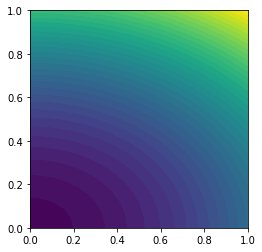

In [ ]:
mesh = UnitSquareMesh(32, 32)

V = FunctionSpace(mesh, 'P', 1)

u = Function(V)
v = TestFunction(V)

f = Constant(-6.)
g = Expression("1+x[0]*x[0] + 2 * x[1]*x[1]", degree=2)
bcs = DirichletBC(V, g, DomainBoundary())

F = inner(nabla_grad(u), nabla_grad(v))*dx - f*v*dx


solve(F==0, u, [bcs])
File("poisson.pvd") << u
plot(u)

The script above solves the variational problem on a discrete, structured, unit, square mesh of 32x32 triangular elements, for given data on the entire boundary of the domain.

Let's break it down in its main parts, providing examples of the use of `FEniCS'` objects.

## Meshes and boundaries

Several tools and functions are available to create meshes and mark parts of their boundaries to enforce boundary conditions.

In the following, we show different approaches which allow for different levels of control of the output mesh.

1) The simplest `Unit*` meshes, from the `dolfin` base library.  

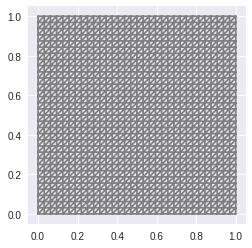

In [ ]:
mesh = UnitSquareMesh(32, 32)
plot(mesh)


This produces a *structured* mesh, where all elements are the same. Variants are available in one, two, and three, dimensions.

See also: `UnitIntervalMesh`, `UnitCubeMesh`, `UnitCircleMesh`, `UnitSphereMesh`, `RectangleMesh` and `BoxMesh`.

Remark: For additional info on the function/class definitions, invoke the help by postponing a question mark to the function/class name, as in  `UnitIntervalMesh?`

In [ ]:
UnitIntervalMesh?

2) Unstructured triangular meshes using the 'Delaunay' algorithm (`tridelaunay`), with control on the average element size.

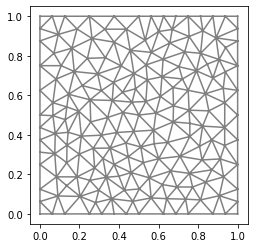

In [ ]:
L = 1.; H = 1.;
cell_size = 0.1;
nel = int(L/cell_size)

geom = Rectangle(Point(0., 0.), Point(L, H))
mesh = generate_mesh(geom, nel)
ndim = mesh.topology().dim() # get number of space dimensions

plot(mesh)

In [ ]:
(mesh.hmin()+mesh.hmax())/2

0.09579983165770649



```
# This is formatted as code
```

3) Boolean operations with geometric primitives

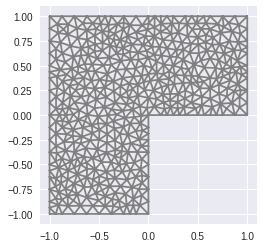

In [ ]:
# Using mshr geometric primitives
# https://bitbucket.org/fenics-project/mshr/wiki/API

square = Rectangle(Point(-1, -1), Point(1, 1))
cutout = Rectangle(Point(+0, -1), Point(1, 0))
domain = square - cutout
mesh   = generate_mesh(domain, 20)
plot(mesh)

4) Exporting a mesh

In [ ]:
File('meshes/complex_mesh.xml') << mesh


5) Importing a mesh

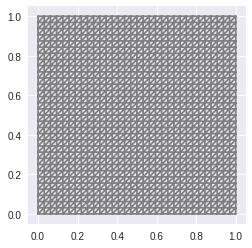

In [ ]:
complex_mesh = Mesh("meshes/complex_mesh.xml")
plot(complex_mesh)

6) Local refinement. 
**This can be skipped at a first read**. It may be useful to locally refine a mesh, this can be done by creating a 2-dimensional boolean field (True/False) indicating the cells selected for refinement, based on a geometric condition. Note that refinement bisects each element and that it can be applied recursively.

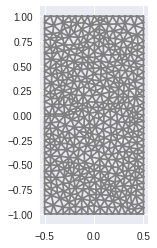

In [ ]:
H = 2
L = 1.

l0 = .2
eta = 0.02
plate = Rectangle(Point(-L/2, -H/2), Point(L/2, H/2))
slit = Rectangle(Point(-L/2, -eta/2), Point(-L/2+l0, eta/2))

domain = plate - slit
mesh   = generate_mesh(domain, 20)
plot(mesh)




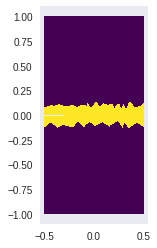

In [ ]:
ref_width = 0.1
dim = 2
# Mark cells for refinement
cell_markers = MeshFunction("bool", mesh, dim)
for c in cells(mesh):
    if -ref_width < c.midpoint()[1] < ref_width:
        cell_markers[c] = True
    else:
        cell_markers[c] = False

plot(cell_markers)


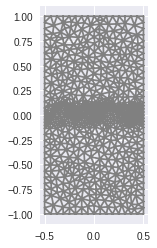

In [ ]:
mesh = refine(mesh, cell_markers)

# Plot mesh
plot(mesh)

refine?

## Fields and their values

To retrieve the value of field at a point, assuming `u` is a `Function` and has some data in it (i.e. comes from the solution of a problem)

In [ ]:
u(0.4, 0.2)

-0.3162840738146212

The array associated to the values along an interval

In [ ]:
xs = np.linspace(0, 1, 20)

[u(x, 0.2) for x in xs]

[0.0,
 -0.09255101998505581,
 -0.17357574377939575,
 -0.2355235948670083,
 -0.2832702142159682,
 -0.31713727158372185,
 -0.33031561588488945,
 -0.3259028141751964,
 -0.305316113378656,
 -0.2715127335600195,
 -0.21742412695534624,
 -0.1474971811309179,
 -0.060753864533894184,
 0.03938980824088257,
 0.15840371044932341,
 0.297429696573483,
 0.44846439683859796,
 0.6160166573093011,
 0.8006991400570306,
 1.0]

Forms (linear and bilinear) can be computed (*assembled*) calling `assemble` 

In [ ]:
en_density = inner(nabla_grad(u), nabla_grad(u)) - f*u
assemble(en_density*dx)

Calling FFC just-in-time (JIT) compiler, this may take some time.


18.66796875

# Finite element function spaces

Throughout the course, we shall use linear $P_1$ finite elements (triangles with linear Lagrange polynomial as shape functions and nodal values as dofs)

In [ ]:
V = FunctionSpace(mesh, 'P', 1)

u = Function(V)
v = TestFunction(V)

For the assembly of the discrete operators, `FEniCS` distinguishes the unknowns (instances of `Function`) from the test functions (instances of `TestFunction`). Here, their associated function space is the same.

# Expressions

Simple expressions can be input as strings, using the `C` syntax for mathematical operations. 

In [ ]:
g = Expression("1 + x[0]*x[0] + 2*x[1]*x[1]", degree=2)

g = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)", degree=2)

g = Expression("-sin(5*x[0])", degree=2)

Expressions can be plotted after a projection/interpolation on a discrete element space. 

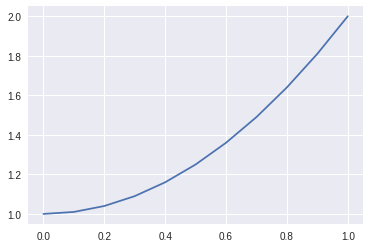

In [ ]:

oned = UnitIntervalMesh(10)
g = Expression("1+x[0]*x[0]", degree=2)

V = FunctionSpace(oned, 'Lagrange', 1)

gi = Function(V)
gi = interpolate(g, V)

plot(gi)

# Boundary conditions

Boundary conditions have to be passed to the solver. There are several ways to specify them. For Dirichlet boundary conditions the `DirichletBC` class requires as arguments
- the function space
- the boundary datum
- the part of the boundary to which it applies.

The class `DomainBoundary()` returns the entire boundary of the mesh associated to the functional space.

In [ ]:
bcs = DirichletBC(V, g, DomainBoundary())

Also, boundaries can be explicitly defined using the coordinates `x[0], ..., x[n]` (in `n`D). Remember to consider numerical round-off errors: never use `==` when (numerically) comparing real numbers.
  
 One way to go is the following

In [ ]:
# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS


The constant `DOLFIN_EPS` is a (small) threshold which is associated to the precision of the machine.

In [ ]:
DOLFIN_EPS

3e-16

Some handy functions are `near()` and `between()`. Check the help for definitions and arguments.

Boundaries are subdomains of the mesh, and can be explicitly *compiled* as an instance of a `CompiledSubDomain`.

Parts of the boundary can be marked using a function that maps the subdomain to a set of integers, as follows 

In [ ]:
L = 1
left = CompiledSubDomain("near(x[0], 0, 1e-4)")
right = CompiledSubDomain("near(x[0], %s, 1e-4)"%L)
boundaries = MeshFunction("size_t", mesh, 1)

boundaries.set_all(0)

left.mark(boundaries, 1) # mark left as 1
right.mark(boundaries, 2) # mark right as 2



**Remark:** marked boundaries can be used to specify boundary measures to be used, for instance, when writing integrals of the type
$$\int_{\partial_N \Omega} f u\,  ds$$

In [ ]:
ds = Measure("ds", subdomain_data=boundaries) # left: ds(1), right: ds(2)

Finally, we can create the `DirichletBC` objects using the marked `boundaries`

In [ ]:
# Displacement
bcu_1 = DirichletBC(V, Constant(0.), boundaries, 1)
bcu_0 = DirichletBC(V, Constant(1.), boundaries, 2)
bc_u = [bcu_0, bcu_1]



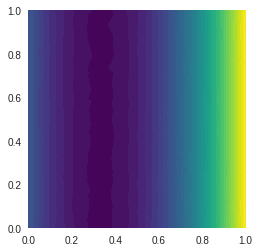

In [ ]:

F = inner(nabla_grad(u), nabla_grad(v))*dx - f*v*dx

solve(F==0, u, bc_u)
File("poisson.pvd") << u
plot(u)

For more complex boundaries, we have access to the `SubDomain` object, its `inside` function, and the coordinates array `x` 

In [ ]:
class ExplicitBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return between(x[1], (.2,.4)) and on_boundary

# TODO
## Solve a modified version of Poisson:
- with given data *on a small part of the boundary*
- with a surface pressure (it enters the variational formulation)
- try to 'manufacture' a solution to a Poisson problem. The easiest is probably considering the system of PDEs in strong form. Indeed, a smooth solution to (*) and (**) has to verify the strong (local) equations and boundary conditions.

Finally, compare:
- The energy of the manufactured solution to that of the numerical solution
- The trace at one of the boundaries



**Online manual**

Here you will find the entire Python API reference

https://fenicsproject.org/docs/dolfin/2018.1.0/python/api.html
